In [ ]:
from ucimlrepo import fetch_ucirepo 
import pandas as pd

from sklearn.model_selection import train_test_split
import numpy as np

# Algorithms
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import balanced_accuracy_score
from sklearn import tree


# data visualization

from matplotlib import pyplot as plt
from matplotlib import style

#Tree Visualization
import graphviz

from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, mean_absolute_error


# Exploração da Base de Dados
- análise de correlação entre os atributos 

## Coleta dos [dados simulados de estabilidade de uma rede elétrica](https://archive.ics.uci.edu/dataset/471/electrical+grid+stability+simulated+data)

In [ ]:
electrical_grid_stability_simulated_data = fetch_ucirepo(id=471).data

features = electrical_grid_stability_simulated_data.features 
targets = electrical_grid_stability_simulated_data.targets # Objetivo

train = pd.merge(features, targets, left_index=True, right_index=True, how='outer')
test = features.copy()


### Atributos

1. tau[x]: reaction time of participant (real from the range [0.5,10]s). Tau1 - the value for electricity producer.
2. p[x]: nominal power consumed(negative)/produced(positive)(real). For consumers from the range [-0.5,-2]s^-2; p1 = abs(p2 + p3 + p4)
3. g[x]: coefficient (gamma) proportional to price elasticity (real from the range [0.05,1]s^-1). g1 - the value for electricity producer.
4. stab: the maximal real part of the characteristic equation root (if positive - the system is linearly unstable)(real)
5. stabf: the stability label of the system (categorical: stable/unstable)



### Entendendo os dados

In [ ]:
features.head()

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4
0,2.959060,3.079885,8.381025,9.780754,3.763085,-0.782604,-1.257395,-1.723086,0.650456,0.859578,0.887445,0.958034
1,9.304097,4.902524,3.047541,1.369357,5.067812,-1.940058,-1.872742,-1.255012,0.413441,0.862414,0.562139,0.781760
2,8.971707,8.848428,3.046479,1.214518,3.405158,-1.207456,-1.277210,-0.920492,0.163041,0.766689,0.839444,0.109853
3,0.716415,7.669600,4.486641,2.340563,3.963791,-1.027473,-1.938944,-0.997374,0.446209,0.976744,0.929381,0.362718
4,3.134112,7.608772,4.943759,9.857573,3.525811,-1.125531,-1.845975,-0.554305,0.797110,0.455450,0.656947,0.820923


In [ ]:
targets.head()

,stab,stabf
0,0.055347,unstable
1,-0.005957,stable
2,0.003471,unstable
3,0.028871,unstable
4,0.049860,unstable


In [ ]:
train.head()

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4,stab,stabf
0,2.959060,3.079885,8.381025,9.780754,3.763085,-0.782604,-1.257395,-1.723086,0.650456,0.859578,0.887445,0.958034,0.055347,unstable
1,9.304097,4.902524,3.047541,1.369357,5.067812,-1.940058,-1.872742,-1.255012,0.413441,0.862414,0.562139,0.781760,-0.005957,stable
2,8.971707,8.848428,3.046479,1.214518,3.405158,-1.207456,-1.277210,-0.920492,0.163041,0.766689,0.839444,0.109853,0.003471,unstable
3,0.716415,7.669600,4.486641,2.340563,3.963791,-1.027473,-1.938944,-0.997374,0.446209,0.976744,0.929381,0.362718,0.028871,unstable
4,3.134112,7.608772,4.943759,9.857573,3.525811,-1.125531,-1.845975,-0.554305,0.797110,0.455450,0.656947,0.820923,0.049860,unstable


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   tau1    10000 non-null  float64
 1   tau2    10000 non-null  float64
 2   tau3    10000 non-null  float64
 3   tau4    10000 non-null  float64
 4   p1      10000 non-null  float64
 5   p2      10000 non-null  float64
 6   p3      10000 non-null  float64
 7   p4      10000 non-null  float64
 8   g1      10000 non-null  float64
 9   g2      10000 non-null  float64
 10  g3      10000 non-null  float64
 11  g4      10000 non-null  float64
 12  stab    10000 non-null  float64
 13  stabf   10000 non-null  object 
dtypes: float64(13), object(1)
memory usage: 1.1+ MB


In [ ]:
targets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   stab    10000 non-null  float64
 1   stabf   10000 non-null  object 
dtypes: float64(1), object(1)
memory usage: 156.4+ KB


In [ ]:
stability = {"stable": 0, "unstable": 1}
targets['stabf'] = targets['stabf'].map(stability) #Esse é o que queremos dar predict no final, portanto:
train['stabf'] = train['stabf'].map(stability)
# train = train.drop(columns=['stab'])
# targets = targets.drop(columns=['stab'])

C:\Users\Veredas\AppData\Local\Temp\ipykernel_5228\418178515.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  targets['stabf'] = targets['stabf'].map(stability) #Esse é o que queremos dar predict no final, portanto:


In [ ]:
targets.head(5)

,stab,stabf
0,0.055347,1
1,-0.005957,0
2,0.003471,1
3,0.028871,1
4,0.049860,1


In [ ]:
train.head(5)

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4,stab,stabf
0,2.959060,3.079885,8.381025,9.780754,3.763085,-0.782604,-1.257395,-1.723086,0.650456,0.859578,0.887445,0.958034,0.055347,1
1,9.304097,4.902524,3.047541,1.369357,5.067812,-1.940058,-1.872742,-1.255012,0.413441,0.862414,0.562139,0.781760,-0.005957,0
2,8.971707,8.848428,3.046479,1.214518,3.405158,-1.207456,-1.277210,-0.920492,0.163041,0.766689,0.839444,0.109853,0.003471,1
3,0.716415,7.669600,4.486641,2.340563,3.963791,-1.027473,-1.938944,-0.997374,0.446209,0.976744,0.929381,0.362718,0.028871,1
4,3.134112,7.608772,4.943759,9.857573,3.525811,-1.125531,-1.845975,-0.554305,0.797110,0.455450,0.656947,0.820923,0.049860,1


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   tau1    10000 non-null  float64
 1   tau2    10000 non-null  float64
 2   tau3    10000 non-null  float64
 3   tau4    10000 non-null  float64
 4   p1      10000 non-null  float64
 5   p2      10000 non-null  float64
 6   p3      10000 non-null  float64
 7   p4      10000 non-null  float64
 8   g1      10000 non-null  float64
 9   g2      10000 non-null  float64
 10  g3      10000 non-null  float64
 11  g4      10000 non-null  float64
 12  stab    10000 non-null  float64
 13  stabf   10000 non-null  int64  
dtypes: float64(13), int64(1)
memory usage: 1.1 MB


In [ ]:
targets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   stab    10000 non-null  float64
 1   stabf   10000 non-null  int64  
dtypes: float64(1), int64(1)
memory usage: 156.4 KB


In [ ]:
corrMatrix = train.corr()


corr_pairs = corrMatrix.unstack().reset_index()
corr_pairs.columns = ['Coluna1', 'Coluna2', 'Correlacao']

# Remover duplicatas e auto-correlacoes
corr_pairs = corr_pairs[corr_pairs['Coluna1'] != corr_pairs['Coluna2']]
corr_pairs = corr_pairs.drop_duplicates(subset=['Correlacao'])

# Ordenar pelo valor absoluto da correlação
corr_max = corr_pairs.sort_values(by='Correlacao', ascending=False)
corr_min = corr_pairs.sort_values(by='Correlacao')

# Selecionar os maiores valores de correlação
print(corr_max.head(10))
print("\n\n\n")
print(corr_min.head(10))

    Coluna1 Coluna2  Correlacao
181    stab   stabf    0.826959
152      g3    stab    0.308235
138      g2    stab    0.293601
26     tau2    stab    0.290975
124      g1    stab    0.282774
40     tau3    stab    0.280700
166      g4    stab    0.279214
54     tau4    stab    0.278576
12     tau1    stab    0.275761
27     tau2   stabf    0.246280




    Coluna1 Coluna2  Correlacao
62       p1      p3   -0.584554
63       p1      p4   -0.579239
61       p1      p2   -0.573157
111      p4   stabf   -0.022785
110      p4    stab   -0.020786
79       p2      g2   -0.018032
35     tau3      p4   -0.017531
3      tau1    tau4   -0.017265
6      tau1      p3   -0.015924
7      tau1      p4   -0.015807


## Limpeza os dados

Temos algumas providencias a serem tomadas antes de excluir ou tomar qualquer outra atitude para correlações baixas

Com os dados acima temos que os g tem grande impacto no stab e o stab tem muito impacto no stabf que é o objetivo final
Portanto o mais importante agora é ver o que fazer com os p

In [ ]:
#Primeira opção
copy_train = train.copy()
# copy_train.head()
copy_train['media_ps'] = (copy_train['p1'] + copy_train['p2'] + copy_train['p3'] + copy_train['p4']) / 4
copy_train['media_gs'] = (copy_train['g1'] + copy_train['g2'] + copy_train['g3'] + copy_train['g4']) / 4
copy_train


,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4,stab,stabf,media_ps,media_gs
0,2.959060,3.079885,8.381025,9.780754,3.763085,-0.782604,-1.257395,-1.723086,0.650456,0.859578,0.887445,0.958034,0.055347,1,-7.216450e-16,0.838878
1,9.304097,4.902524,3.047541,1.369357,5.067812,-1.940058,-1.872742,-1.255012,0.413441,0.862414,0.562139,0.781760,-0.005957,0,-1.665335e-16,0.654938
2,8.971707,8.848428,3.046479,1.214518,3.405158,-1.207456,-1.277210,-0.920492,0.163041,0.766689,0.839444,0.109853,0.003471,1,0.000000e+00,0.469757
3,0.716415,7.669600,4.486641,2.340563,3.963791,-1.027473,-1.938944,-0.997374,0.446209,0.976744,0.929381,0.362718,0.028871,1,-2.498002e-16,0.678763
4,3.134112,7.608772,4.943759,9.857573,3.525811,-1.125531,-1.845975,-0.554305,0.797110,0.455450,0.656947,0.820923,0.049860,1,1.249001e-15,0.682607
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,2.930406,9.487627,2.376523,6.187797,3.343416,-0.658054,-1.449106,-1.236256,0.601709,0.779642,0.813512,0.608385,0.023892,1,-1.665335e-16,0.700812
9996,3.392299,1.274827,2.954947,6.894759,4.349512,-1.663661,-0.952437,-1.733414,0.502079,0.567242,0.285880,0.366120,-0.025803,0,-7.771561e-16,0.430330
9997,2.364034,2.842030,8.776391,1.008906,4.299976,-1.380719,-0.943884,-1.975373,0.487838,0.986505,0.149286,0.145984,-0.031810,0,4.996004e-16,0.442403
9998,9.631511,3.994398,2.757071,7.821347,2.514755,-0.966330,-0.649915,-0.898510,0.365246,0.587558,0.889118,0.818391,0.037789,1,1.026956e-15,0.665078


In [ ]:
corrMatrix = copy_train.corr()


corr_pairs = corrMatrix.unstack().reset_index()
corr_pairs.columns = ['Coluna1', 'Coluna2', 'Correlacao']

# Remover duplicatas e auto-correlacoes
corr_pairs = corr_pairs[corr_pairs['Coluna1'] != corr_pairs['Coluna2']]
corr_pairs = corr_pairs.drop_duplicates(subset=['Correlacao'])

# Ordenar pelo valor absoluto da correlação
corr_max = corr_pairs.sort_values(by='Correlacao', ascending=False)
corr_min = corr_pairs.sort_values(by='Correlacao')

# Selecionar os maiores valores de correlação
print(corr_max.head(5))
print("\n\n\n")
print(corr_min.head(5))

    Coluna1   Coluna2  Correlacao
205    stab     stabf    0.826959
207    stab  media_gs    0.582884
143      g1  media_gs    0.507925
191      g4  media_gs    0.503049
175      g3  media_gs    0.494952




    Coluna1   Coluna2  Correlacao
70       p1        p3   -0.584554
71       p1        p4   -0.579239
69       p1        p2   -0.573157
222   stabf  media_ps   -0.029486
206    stab  media_ps   -0.026234


Logo na primeira opção ao criar duas novas colunas, tivemos um bom achado com a média dos gs e um péssimo com a média dos ps

Optamos por excluir todos os valores de ps para o ML.

# Formatação dos Dados

### Substituindo valores de texto para número (teste)

In [ ]:
stability = {"unstable": 0, "stable": 1}

# for dataset in all:
#     dataset['stabf'] = dataset['stabf'].map(stability)
train.describe()

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4,stab,stabf
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,5.250000,5.250001,5.250004,5.249997,3.750000,-1.250000,-1.250000,-1.250000,0.525000,0.525000,0.525000,0.525000,0.015731,0.638000
std,2.742548,2.742549,2.742549,2.742556,0.752160,0.433035,0.433035,0.433035,0.274256,0.274255,0.274255,0.274255,0.036919,0.480603
min,0.500793,0.500141,0.500788,0.500473,1.582590,-1.999891,-1.999945,-1.999926,0.050009,0.050053,0.050054,0.050028,-0.080760,0.000000
25%,2.874892,2.875140,2.875522,2.874950,3.218300,-1.624901,-1.625025,-1.624960,0.287521,0.287552,0.287514,0.287494,-0.015557,0.000000
50%,5.250004,5.249981,5.249979,5.249734,3.751025,-1.249966,-1.249974,-1.250007,0.525009,0.525003,0.525015,0.525002,0.017142,1.000000
75%,7.624690,7.624893,7.624948,7.624838,4.282420,-0.874977,-0.875043,-0.875065,0.762435,0.762490,0.762440,0.762433,0.044878,1.000000
max,9.999469,9.999837,9.999450,9.999443,5.864418,-0.500108,-0.500072,-0.500025,0.999937,0.999944,0.999982,0.999930,0.109403,1.000000


### Como observado na seção anterior, fica claro a necessidade de alguma decisão em relação a base de dados
Portanto excluimos todos os valores das colunas ps

Essa parte só pode ser executada uma vez

In [ ]:
print(train)
train = train.drop(columns=['p1'])
train = train.drop(columns=['p2'])
train = train.drop(columns=['p3'])
train = train.drop(columns=['p4'])


          tau1      tau2      tau3      tau4        p1        p2        p3  \
0     2.959060  3.079885  8.381025  9.780754  3.763085 -0.782604 -1.257395   
1     9.304097  4.902524  3.047541  1.369357  5.067812 -1.940058 -1.872742   
2     8.971707  8.848428  3.046479  1.214518  3.405158 -1.207456 -1.277210   
3     0.716415  7.669600  4.486641  2.340563  3.963791 -1.027473 -1.938944   
4     3.134112  7.608772  4.943759  9.857573  3.525811 -1.125531 -1.845975   
...        ...       ...       ...       ...       ...       ...       ...   
9995  2.930406  9.487627  2.376523  6.187797  3.343416 -0.658054 -1.449106   
9996  3.392299  1.274827  2.954947  6.894759  4.349512 -1.663661 -0.952437   
9997  2.364034  2.842030  8.776391  1.008906  4.299976 -1.380719 -0.943884   
9998  9.631511  3.994398  2.757071  7.821347  2.514755 -0.966330 -0.649915   
9999  6.530527  6.781790  4.349695  8.673138  3.492807 -1.390285 -1.532193   

            p4        g1        g2        g3        g4      sta

In [ ]:
train['media_gs'] = (train['g1'] + train['g2'] + train['g3'] + train['g4']) / 4

In [ ]:
corrMatrix = train.corr()


corr_pairs = corrMatrix.unstack().reset_index()
corr_pairs.columns = ['Coluna1', 'Coluna2', 'Correlacao']

# Remover duplicatas e auto-correlacoes
corr_pairs = corr_pairs[corr_pairs['Coluna1'] != corr_pairs['Coluna2']]
corr_pairs = corr_pairs.drop_duplicates(subset=['Correlacao'])

# Ordenar pelo valor absoluto da correlação
corr_max = corr_pairs.sort_values(by='Correlacao', ascending=False)
corr_min = corr_pairs.sort_values(by='Correlacao')

# Selecionar os maiores valores de correlação
print(corr_max.head(5))
print("\n\n\n")
print(corr_min.head(5))


   Coluna1   Coluna2  Correlacao
97    stab     stabf    0.826959
98    stab  media_gs    0.582884
54      g1  media_gs    0.507925
87      g4  media_gs    0.503049
76      g3  media_gs    0.494952




   Coluna1 Coluna2  Correlacao
3     tau1    tau4   -0.017265
62      g2      g4   -0.014909
61      g2      g3   -0.012809
18    tau2      g4   -0.011764
26    tau3      g1   -0.011605


# Separar a base em Treino (80%) e Teste (20%)

In [ ]:
print(train)
r_train, r_test = train_test_split(train, test_size=0.2, random_state=0)
print(r_train)

          tau1      tau2      tau3      tau4        g1        g2        g3  \
0     2.959060  3.079885  8.381025  9.780754  0.650456  0.859578  0.887445   
1     9.304097  4.902524  3.047541  1.369357  0.413441  0.862414  0.562139   
2     8.971707  8.848428  3.046479  1.214518  0.163041  0.766689  0.839444   
3     0.716415  7.669600  4.486641  2.340563  0.446209  0.976744  0.929381   
4     3.134112  7.608772  4.943759  9.857573  0.797110  0.455450  0.656947   
...        ...       ...       ...       ...       ...       ...       ...   
9995  2.930406  9.487627  2.376523  6.187797  0.601709  0.779642  0.813512   
9996  3.392299  1.274827  2.954947  6.894759  0.502079  0.567242  0.285880   
9997  2.364034  2.842030  8.776391  1.008906  0.487838  0.986505  0.149286   
9998  9.631511  3.994398  2.757071  7.821347  0.365246  0.587558  0.889118   
9999  6.530527  6.781790  4.349695  8.673138  0.073056  0.505441  0.378761   

            g4      stab  stabf  media_gs  
0     0.958034  0.0

# Executar o Treinamento e Validação do Modelo Escolhido

In [ ]:
from sklearn.model_selection import KFold
from sklearn import linear_model
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Supondo que 'train' seja seu DataFrame com dados
kf = KFold(n_splits=5, random_state=0, shuffle=True)

# Listas para armazenar as métricas para Lasso e DecisionTree
mse_l = []
mae_l = []
mape_l = []
r2_l = []

mse_r = []
mae_r = []
mape_r = []
r2_r = []

for i, (train_index, test_index) in enumerate(kf.split(train)):
    # Dividir os dados em treino e teste
    Y_train = train.values[train_index][:, 3]
    X_train = train.values[train_index]
    X_train = np.delete(X_train, 3, 1)  # Remove a coluna alvo

    Y_test = train.values[test_index][:, 3]
    X_test = train.values[test_index]
    X_test = np.delete(X_test, 3, 1)  # Remove a coluna alvo

    # Treinar e avaliar o modelo Lasso
    reg_l = linear_model.Lasso(alpha=0.1)
    reg_l.fit(X_train, Y_train)
    Y_pred_l = reg_l.predict(X_test)

    mse_l.append(mean_squared_error(Y_test, Y_pred_l))
    mape_l.append(np.mean(np.abs((Y_test - Y_pred_l) / Y_test)) * 100)
    mae_l.append(mean_absolute_error(Y_test, Y_pred_l))
    r2_l.append(r2_score(Y_test, Y_pred_l))

    # Treinar e avaliar o modelo DecisionTreeRegressor
    reg_r = DecisionTreeRegressor(max_depth=5, splitter='random', min_samples_leaf=5)
    reg_r.fit(X_train, Y_train)
    Y_pred_r = reg_r.predict(X_test)

    mse_r.append(mean_squared_error(Y_test, Y_pred_r))
    mape_r.append(np.mean(np.abs((Y_test - Y_pred_r) / Y_test)) * 100)
    mae_r.append(mean_absolute_error(Y_test, Y_pred_r))
    r2_r.append(r2_score(Y_test, Y_pred_r))



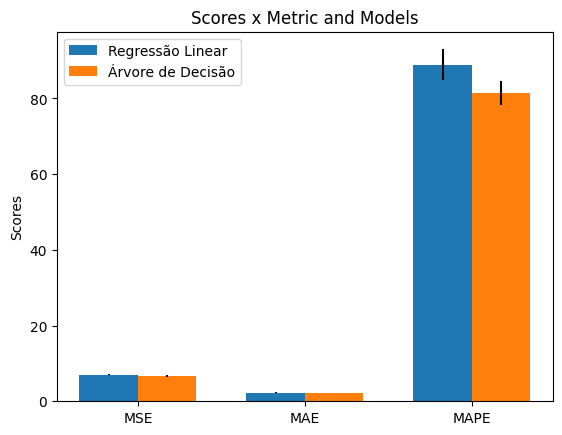

mean MSE with decision tree regressor 6.6814280452775225
mean MAE with decision tree regressor 2.187527806930789
mean MAPE with decision tree regressor 81.41727798501992


mean MSE with linear regression 7.05980184320458
mean MAE with linear regression 2.2937567398012857
mean MAPE with linear regression 88.94807835537921


In [ ]:
# Regressão Linear
metrics_l = {'MSE': mse_l, 'MAE': mae_l, 'MAPE': mape_l}
mean_std_l = {metric: (np.mean(scores), np.std(scores)) for metric, scores in metrics_l.items()}

# Árvore de Decisão
metrics_r= {'MSE': mse_r, 'MAE': mae_r, 'MAPE': mape_r}
mean_std_r = {metric: (np.mean(scores), np.std(scores)) for metric, scores in metrics_r.items()}

# Plotando os gráficos
metrics_labels = ['MSE', 'MAE', 'MAPE']
width = 0.35
x = np.arange(len(metrics_labels))

fig, ax = plt.subplots()

rects1 = ax.bar(x - width/2, [mean_std_l[metric][0] for metric in metrics_labels], width, label='Regressão Linear', yerr=[mean_std_l[metric][1] for metric in metrics_labels])
rects2 = ax.bar(x + width/2, [mean_std_r[metric][0] for metric in metrics_labels], width, label='Árvore de Decisão', yerr=[mean_std_r[metric][1] for metric in metrics_labels])

ax.set_ylabel('Scores')
ax.set_title('Scores x Metric and Models')
ax.set_xticks(x)
ax.set_xticklabels(metrics_labels)
ax.legend()


plt.show()

for index in mean_std_r:
  print(f'mean {index} with decision tree regressor {mean_std_r[index][0]}')

print("\n")

for index in mean_std_l:
  print(f'mean {index} with linear regression {mean_std_l[index][0]}')




# Conclusão

Responder à pergunta: "Você acredita que será possível entregar tudo que prometeu no documento da Proposta?"


Sim, por mais que esteja apenas no começo do projeto, já é possivel fazer algumas análises utilizando regressão linear e arvore de regressão como visto em aula, com o que já temos fica facil crial pipelines para os ajustes nos dados e também abre a possibilidade para random forests. Com o objetivo final de evitar overfitting e garantir também que seja possivel obter respostas e tomadas de decisões razoáveis em relação aos dados estabelecidos.